In [13]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

In [15]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

In [16]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here - decoder: x -> sin(x)

In [98]:
def gen_xy_sin_to_f(n_samples=500, n_t=100, f=None, dt=0.01):
    # x_train = array (unique_samples, xs_over_t, sin(xs))
    # y_train = array (unique_samples, xs_over_t, sin(xs + dx))
    max_t = n_t * dt
    min_f = utils.min_f(max_t)
    max_f = utils.max_f(dt)
    print('allowed min max f', min_f, max_f)
    min_f = 9
    max_f = 9
    if f is None:
        fs = np.random.random(n_samples) * (max_f - min_f) + min_f
    else:
        fs = np.repeat(f, n_samples)
        
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []    
    for i, phase in enumerate(phases):
        # x: beginning of cycle
        f = fs[i]
        d_phase = n_t * dt * f
        x_train.append(sin_(n_t, f, phase))
        # y: continuation of cycle        
        y_train.append(sin_(n_t, f, phase + d_phase))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, 1) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, 1)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01):
    ts = np.arange(n) * dt
    return (np.sin(2*np.pi * f * ts + phase * 2 * np.pi) + 1) * 0.5

In [99]:
n = 500
f = None
# f = 3
dt = 0.01
x_train, y_train = gen_xy_sin_to_f(n, f=f, dt=dt)
y_train = x_train
x_test, y_test = gen_xy_sin_to_f(10, f=f, dt=dt)
print(x_train.shape, y_train.shape)

allowed min max f 1.0 50.0
allowed min max f 1.0 50.0
(500, 100, 1) (500, 100, 1)


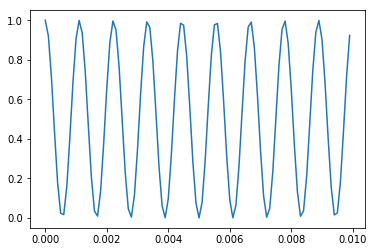

In [100]:
n4 = x_train.shape[1]
plt.plot(np.arange(n4) / n4 * dt, x_train[0])

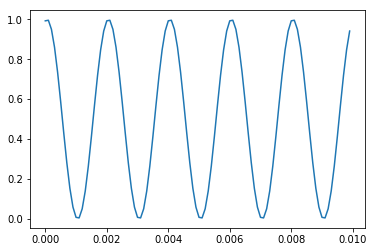

In [27]:
plt.plot(np.arange(n4) / n4 * dt, y_train[0])

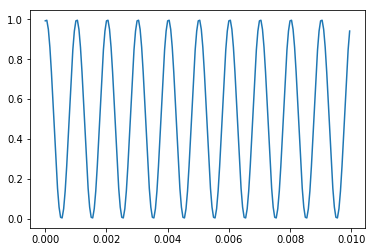

In [28]:
full = np.concatenate([x_train[0],y_train[0]])
n5 = full.shape[0]
plt.plot(np.arange(n5) / n5 * dt, full)

In [29]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(100, 1)

In [30]:
output_shape

(100, 1)

In [101]:
# def model(input_shape, output_shape):
"""
encoded, states = lstm(input())
decoded
while predicting (for every timestep): 
    decoded <- lstm(input() ++ states) # ++ decoded?
"""

# input shape = (None, None, 1)
# thus: unfixed n samples, unfixed n timesteps, 1 float value
encoder_input = Input(shape=(None,1))
hidden_size = 128
# discard the direct output of the encoder_lstm
_, state_h, state_c = LSTM(hidden_size, return_state=True)(encoder_input)
encoder_states = [state_h, state_c]

decoder_input = Input(shape=(None, 1))
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
print('dims decoder_output =', keras.backend.int_shape(decoder_output))


w = np.prod(output_shape)
print('w =',w)
decoder_dense = Dense(w, activation='softmax')
decoder_output = decoder_dense(decoder_output)
decoder_dense = Dense(1, activation='softmax')
decoder_output = decoder_dense(decoder_output)
print('dims decoder_dense =', keras.backend.int_shape(decoder_output))
# decoder_reshape = Reshape(output_shape)
# decoder_output = decoder_reshape(decoder_output)
# print('dims decoder_reshape =', keras.backend.int_shape(decoder_output))


#     model = Model(inputs=input_layer, outputs=x)
model = Model([encoder_input, decoder_input], decoder_output)
#     return model

# model = model(input_shape, output_shape)
model.summary()

dims decoder_output = (None, None, 128)
w = 100
dims decoder_dense = (None, None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_33 (LSTM)                  [(None, 128), (None, 66560       input_33[0][0]                   
__________________________________________________________________________________________________
lstm_34 (LSTM)                  [(None, None, 128),  66560       input_34[0][0]                   
                        

In [102]:
# encoder.summary()
# decoder.summary()

In [103]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adadelta' # adam adadelta rmsprop
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [104]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 6

In [ ]:
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
model.fit([x_train,x_train], y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 416 samples, validate on 84 samples


# Inferencing

In [81]:
def decode_sequence(input_seq, encoder):
    # Encode the input as state vectors.
    states_value = encoder.predict(input_seq)

    # Generate empty target sequence of length 1.
    num_decoder_tokens = 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 1] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

# decode_sequence

In [91]:
x_test.shape

(10, 100, 1)

In [92]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [93]:
results = model.predict([x_test,x_test])
results.shape

(10, 100, 1)

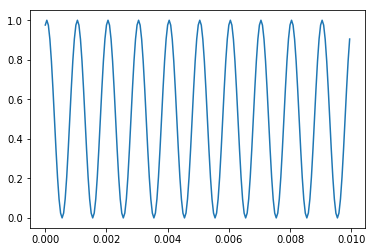

In [94]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

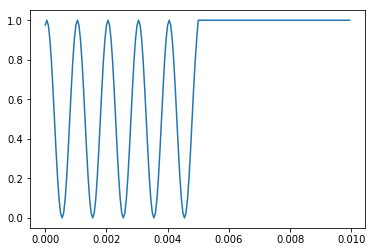

In [95]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

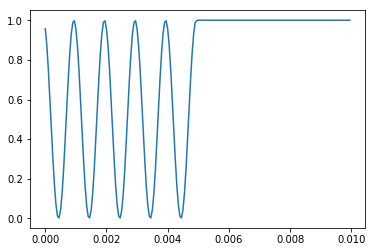

In [96]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

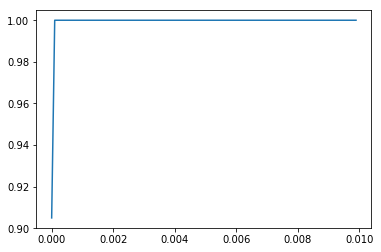

In [97]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)